In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import networkx as nx
import torch
from torch_geometric.data import Dataset, Data, Batch
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
import torch_geometric as pyg
import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary
from pytorch_lightning.loggers import WandbLogger
import wandb

from utils.gnn_utils import *
from utils.gnn import *
from utils.module import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

In [3]:
sc_data = sc.read_h5ad("data/Allenbrain_forSimulation_uniquect.h5ad")

In [4]:
st_data, X_real, X_sim, y_sim = load_data(
    st_path="data/V1_Mouse_Brain_Sagittal_Anterior.h5ad",
    gene_expr_path="experiment/datasets",
)


/root/miniconda3/envs/dissect_spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
sim_data = sc.read_h5ad("PropsSimulator/simulation/simulated.h5ad")

## Prepare graph dataset

In [5]:
train_data = prepare_dataset(
    st_data, X_real, X_sim, y_sim, num_samples=20, num_hops=5, p=0.2, sample_sugraphs=False
)


/root/miniconda3/envs/dissect_spatial/lib/python3.8/site-packages/torch_geometric/utils/convert.py:250: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


In [6]:
train_data[0]

[Data(x=[2695, 11320], edge_index=[2, 18351], pos=[2695, 2], edge_weight=[18351]),
 Data(x=[2695, 11320], edge_index=[2, 1449552], y=[2695, 23]),
 Data(x=[2695, 11320], edge_index=[2, 18351])]

In [6]:
test_data = prepare_dataset(
    st_data, X_real, X_sim, y_sim, num_samples=1, sample_sugraphs=False, p=0.2, test=True
)


In [8]:
test_data[0]

[Data(x=[2695, 11320], edge_index=[2, 18351], pos=[2695, 2], edge_weight=[18351]),
 Data(),
 Data()]

In [7]:
train_loader = DataLoader(train_data, batch_size=6, shuffle=True, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True, num_workers=0)

## Training routine

In [8]:
# setup network and model
net = CelltypeDeconvolver(
    num_genes=X_real.shape[1], num_celltypes=y_sim.shape[1], latent_dim=64
)
model = DeconvolutionModel(net)

In [9]:
wandb.finish()
wandb_mode = "online"
wandb_mode = "disabled"
wandb_logger = WandbLogger(project="dissect-spatial", log_model=False, mode=wandb_mode)

# training
trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="gpu",
    limit_train_batches=2,
    log_every_n_steps=1,
    devices=[7],
    precision=32,
    logger=wandb_logger,
    enable_checkpointing=False,
    fast_dev_run=True,
)

trainer.fit(model, train_loader)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                | Params
---------------------------------------------
0 | net  | CelltypeDeconvolver | 5.8 M 
---------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.373    Total estimated model params size (MB)
/root/miniconda3/envs/dissect_spatial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottl

Training: 0it [00:00, ?it/s]

/root/miniconda3/envs/dissect_spatial/lib/python3.8/site-packages/torch/nn/functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
`Trainer.fit` stopped: `max_steps=1` reached.


In [ ]:
summary = ModelSummary(model, max_depth=-1)
print(summary)

## Perform actual deconvolution

In [12]:
result = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 2it [00:00, ?it/s]

## Evaluate result

In [13]:
# extract max cell type per node
# plot with squidpy
cell_type_indices = np.array(np.argmax(result[0], axis=1))

In [14]:
with open("experiment/datasets/celltypes.txt", "r") as f:
    cell_type_list = f.readlines()
cell_type_list = [x.strip() for x in cell_type_list][1::]

In [15]:
# map celltypes onto cdelltype list
cell_types = [cell_type_list[i] for i in cell_type_indices]

In [16]:
st_data.obs["celltype"] = cell_types

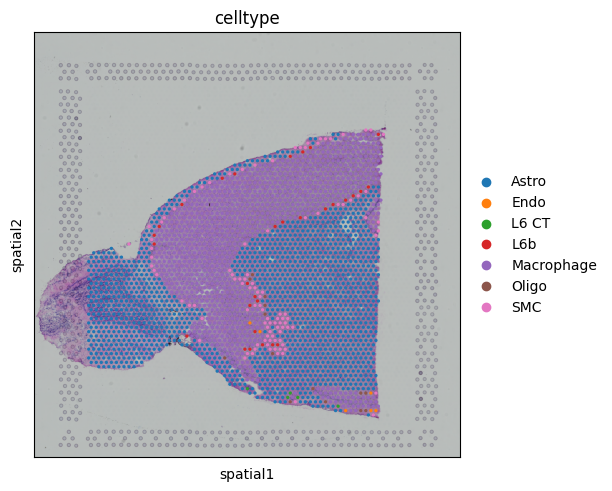

In [17]:
sq.pl.spatial_scatter(st_data, color=["celltype"])